In [3]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as pplot

from astrotate import array, utils, server, treatment
from astrotate.ep import ep
import importlib
import shutil
from datetime import datetime

In [ ]:
importlib.reload(ep)
importlib.reload(utils)

In [ ]:
# !git


# Define the experiment folder

In [82]:
exp_date = '191112' # <==== set experiment date as folder name.

exp_folder = '/Users/Melody/Documents/expdata'
#'C:\\Shared_Experimental_Data' # Don't need to change if you use it in this computer.

# ===================don't change below part =======================================================
today_folder = os.path.join(exp_folder, exp_date)  
template_file = 'data_log_template.xlsx'
target_template_file = os.path.join(today_folder, template_file)
if not os.path.exists(target_template_file):
    shutil.copyfile(template_file, target_template_file)

## Animal info

In [83]:
date = datetime.strptime(exp_date, '%y%m%d')
animalid = 'A'+date.strftime('%Y%m%d')+'01'

gender = 'M' # M F
species = 'rat' # rat mouse
strain = 'SD' # SD    C57BL/6J
weight = 464

animalinfo = {}
animalinfo['sub_bleeding']= 'N'
animalinfo['brain_bloom'] = 'N'
animalinfo['give_oxygen'] = 'Y'
#treatment = info['treatment']

pilot = False

In [4]:
t={}
t['0'] = treatment.Baseline().toDict()
t['1'] = treatment.CSD().toDict()

=== baseline treatment start time.===
Press Enter to leave it blank. Input 1 for present time. Input HH:MM for certain time:  
=== baseline treatment start date.===
Press Enter to ignore this.
Input 1 for today.
Input mm-dd-yyyy for detail date:  


Treatment operator:  Press Enter for Jun Zhao
0 ---> Jun Zhao
1 ---> Dara Bree
2 ---> Andrew Blaeser


Select by idx:  
input your note for baseline treatment:  
=== CSD treatment start time.===
Press Enter to leave it blank. Input 1 for present time. Input HH:MM for certain time:  
=== CSD treatment start date.===
Press Enter to ignore this.
Input 1 for today.
Input mm-dd-yyyy for detail date:  


Treatment operator:  Press Enter for Jun Zhao
0 ---> Jun Zhao
1 ---> Dara Bree
2 ---> Andrew Blaeser


Select by idx:  
input your note for CSD treatment:  


Choose CSD method: 
0 ---> pinprick
1 ---> KCl


Select by idx:  0


In [5]:
t

{'0': {'method': 'baseline',
  'time': '',
  'date': '',
  'operator': 'Jun Zhao',
  'parameters': {},
  'note': ''},
 '1': {'method': 'CSD',
  'time': '',
  'date': '',
  'operator': 'Jun Zhao',
  'parameters': {'apply_method': 'pinprick'},
  'note': ''}}

In [9]:
#conn = server.connect_server()

cur = conn.cursor()
cur.execute(
"""
update ep_info 
set gender = 'M'
where animalid = 'A2019110801'
"""
)
conn.commit()
conn.close()

In [86]:
conn = server.connect_server()

cur = conn.cursor()
cur.execute(
"""
INSERT INTO ep_info (animalid, animalinfo, date, weight, gender, species, strain, treatment, pilot)
VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
""", (animalid, json.dumps(animalinfo), date, weight, gender, species, strain, json.dumps(t), pilot)
)
conn.commit()

## please fill the form then run the next step

In [56]:
treatment_df = pd.read_excel(target_template_file, sheet_name = 'treatment').astype({'trial': 'str'})
trial_df = pd.read_excel(target_template_file, sheet_name = 'trials').astype({'trial': 'str'})
channel_df = pd.read_excel(target_template_file, sheet_name = 'channel').dropna(subset=['channel_name'], inplace=False).reset_index(inplace=False)

In [57]:
channel_df

,index,data_type,channel_name,output_bin_secsize
0,0,bf,1 BF,5.000
1,1,multiunit,5 TG,1.000
2,2,ECoG,7 highC,0.001


In [9]:
def bint1D(array, binsize, setint = False):
    # smooth 1D array
    remains = len(array) % binsize
    array1 = np.reshape(array[0:len(array)-remains], [-1, binsize])
    array2 = np.mean(array1, axis = 1)
    if remains > binsize/2:
        array2 = np.append(array2, np.mean(array[-remains:]))
    if setint:
        array2 = np.around(array2).astype(int)
    return(array2)

def get_array(expfolder = today_folder, treatment_df = treatment_df, trial_df = trial_df, channel_df = channel_df):
    
    #treatment_df = treatment_df.astype({'trial': 'str'}) # after load from csv, the trial is int64
    trials = os.listdir(expfolder)
    required_trials = [str(x)+'.txt' for x in trial_df.loc[:, 'trial'].values]
    files = [os.path.join(expfolder,x) for x in trials if x.split('-')[-1] in required_trials]
    
    files.sort()
    data = {}
    for i in range(len(channel_df)):
        thetype = channel_df.loc[i, 'data_type']
        data[thetype] = {'present_length':0, 'data':[], 'treat_point': {}, 'bin_size':str(channel_df.loc[i, 'output_bin_secsize'])+'sec'}
        channel = channel_df.loc[i, 'channel_name']
        scanRate = channel_df.loc[i, 'output_bin_secsize']
        print('start to extract %s data' % thetype)

        for j in range(len(files)):
            file = files[j]
            outputRate = trial_df.loc[i, 'output_freq']
            df = pd.read_csv(file, sep = '\t')
            values = df.loc[:, channel].values
            values = values[~np.isnan(values)]
            values = bint1D(values, int(scanRate*outputRate), setint = (channel in ['multiunit']))
            data[thetype]['data'] = np.append(data[thetype]['data'], values)

            tmp_trial = file.split('-')[-1][0:-4]
            #timepoint_df.loc[len(timepoint_df), :] = [tmp_trial, len(values)]
            print('%s done, length is %d' % (file, len(values)))
            if tmp_trial in treatment_df.loc[:, 'trial'].tolist():
                
                tmp_row = treatment_df.index[treatment_df.loc[:, 'trial'] == tmp_trial].tolist()[0]
                tmp_id = str(treatment_df.loc[tmp_row, 'treatment_id'])
                tmp_sec = treatment_df.loc[tmp_row, 'sec']#.value#astype(float)
                # print(tmp_trial, tmp_id, tmp_sec)
                data[thetype]['treat_point'][tmp_id] = data[thetype]['present_length'] + int(tmp_sec/scanRate)
                # print(data[thetype]['present_length'], int(tmp_sec/outputRate))
                # print(data[thetype]['treat_point'][tmp_id])

            data[thetype]['present_length'] = data[thetype]['present_length'] + len(values)
    return(data)
    
def create_data_info(data):
    datainfo = {}
    for key, value in data.items():
        datainfo[key] = {}
        datainfo[key]['treat_point'] = value['treat_point']
        datainfo[key]['bin_size'] = value['bin_size']
        datainfo[key]['file_path'] = key+'.csv'
        
        if key == 'bf':
            fmt = '%.3e'
            
        elif key == 'multiunit':
            fmt = '%d'
            
        elif key == 'ECoG':
            fmt = '%.4e'
            
        np.savetxt(os.path.join(today_folder, datainfo[key]['file_path']), value['data'], fmt = fmt)
        print('%s data saved at %s' % (key, os.path.join(today_folder, datainfo[key]['file_path'])))
    
    utils.writejson(os.path.join(today_folder, 'datainfo.json'), datainfo)
    return(datainfo)

def tidy_ecog_data(datainfo, csdkey): # As ECoG data pretty big, I don't want to save whole period. Now I will just save from 10 min before CSD and 1 h after CSD.
    data = np.loadtxt(os.path.join(today_folder, datainfo['ECoG']['file_path']))
    points_before_csd = 10 * 60 / float(datainfo['ECoG']['bin_size'][:-3])
    points_after_csd = 60 * 60 / float(datainfo['ECoG']['bin_size'][:-3])
    t0 = int(datainfo['ECoG']['treat_point'][csdkey] - points_before_csd)
    t1 = int(datainfo['ECoG']['treat_point'][csdkey] + points_after_csd)
    newdata = data[t0:t1]
    np.savetxt(os.path.join(today_folder, datainfo['ECoG']['file_path']), newdata)
    newdic = {}
    for key, value in datainfo['ECoG']['treat_point'].items():
        if value - t0 > 0:
            newdic[key] = value - t0
    datainfo['ECoG']['treat_point'] = newdic
    utils.writejson(os.path.join(today_folder, 'datainfo.json'), datainfo)
    
    


        
    

In [58]:
data = get_array(expfolder = today_folder, treatment_df = treatment_df, trial_df = trial_df, channel_df = channel_df)

start to extract bf data
/Users/Melody/Documents/expdata/191113/spon-Nov-13-19-13-55-2558.txt done, length is 360
/Users/Melody/Documents/expdata/191113/spon-Nov-13-19-14-25-2559.txt done, length is 360
/Users/Melody/Documents/expdata/191113/spon-Nov-13-19-14-40-2560.txt done, length is 177
start to extract multiunit data
/Users/Melody/Documents/expdata/191113/spon-Nov-13-19-13-55-2558.txt done, length is 1800
/Users/Melody/Documents/expdata/191113/spon-Nov-13-19-14-25-2559.txt done, length is 1800
/Users/Melody/Documents/expdata/191113/spon-Nov-13-19-14-40-2560.txt done, length is 885
start to extract ECoG data
/Users/Melody/Documents/expdata/191113/spon-Nov-13-19-13-55-2558.txt done, length is 1800312
/Users/Melody/Documents/expdata/191113/spon-Nov-13-19-14-25-2559.txt done, length is 1800458
/Users/Melody/Documents/expdata/191113/spon-Nov-13-19-14-40-2560.txt done, length is 885471


In [59]:
data['bf']['treat_point']

{'0': 0}

In [60]:
datainfo = create_data_info(data) # This function will create both datainfo.json and also save data to each csv files.
print(datainfo)

bf data saved at /Users/Melody/Documents/expdata/191113/bf.csv
multiunit data saved at /Users/Melody/Documents/expdata/191113/multiunit.csv
ECoG data saved at /Users/Melody/Documents/expdata/191113/ECoG.csv
{'bf': {'treat_point': {'0': 0}, 'bin_size': '5.0sec', 'file_path': 'bf.csv'}, 'multiunit': {'treat_point': {'0': 0}, 'bin_size': '1.0sec', 'file_path': 'multiunit.csv'}, 'ECoG': {'treat_point': {'0': 0}, 'bin_size': '0.001sec', 'file_path': 'ECoG.csv'}}


In [7]:
# This is a dangerous function. Please make sure your parameters before you run this function. 
# It will crop your data and overwrite the old file.

tidy_ecog_data(datainfo, '2') 

In [63]:
datainfo['ECoG']['treat_point'] = {'0':0, '1':300000}
print(datainfo)

{'bf': {'treat_point': {'0': 0, '1': 60}, 'bin_size': '5.0sec', 'file_path': 'bf.csv'}, 'multiunit': {'treat_point': {'0': 0, '1': 300}, 'bin_size': '1.0sec', 'file_path': 'multiunit.csv'}, 'ECoG': {'treat_point': {'0': 0, '1': 300000}, 'bin_size': '0.001sec', 'file_path': 'ECoG.csv'}}


In [64]:
# add in bf db
conn = server.connect_server()
cur = conn.cursor()
cur.execute(
"""
INSERT INTO ep_data_bf (animalid, treat_point, filepath)
VALUES (%s, %s, %s)
""", ('A'+datetime.strptime(exp_date, '%y%m%d').strftime('%Y%m%d')+'01', 
      json.dumps(datainfo['bf']['treat_point']), 
      'bf'+datetime.strptime(exp_date, '%y%m%d').strftime('%Y%m%d')+'01.csv'
     )
)
conn.commit()
conn.close()

In [65]:
# add in ECoG db
conn = server.connect_server()
cur = conn.cursor()
cur.execute(
"""
INSERT INTO ep_data_ecog (animalid, treat_point, filepath, scanrate)
VALUES (%s, %s, %s, 1000)
""", ('A'+datetime.strptime(exp_date, '%y%m%d').strftime('%Y%m%d')+'01', 
      json.dumps(datainfo['ECoG']['treat_point']), 
      'ecog'+datetime.strptime(exp_date, '%y%m%d').strftime('%Y%m%d')+'01.csv'
     )
)
conn.commit()
conn.close()

In [66]:
# add in multiunit db
conn = server.connect_server()
cur = conn.cursor()
cur.execute(
"""
INSERT INTO ep_data_multiunit (animalid, treat_point, filepath, scanrate)
VALUES (%s, %s, %s, 1)
""", ('A'+datetime.strptime(exp_date, '%y%m%d').strftime('%Y%m%d')+'01', 
      json.dumps(datainfo['multiunit']['treat_point']), 
      'multi'+datetime.strptime(exp_date, '%y%m%d').strftime('%Y%m%d')+'01.csv'
     )
)
conn.commit()
conn.close()

# Check the output

4288916


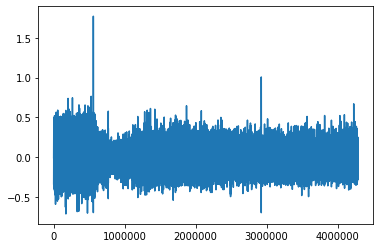

In [14]:
# The channel you want to check:
channel = 'ECoG' # bf multiunit ECoG
d = np.loadtxt(os.path.join(os.path.join(today_folder, channel+'.csv')))
print(len(d))
pplot.plot(d)

In [ ]:
# np.savetxt(os.path.join(exp_folder, output_file_name), data, fmt='%.4e', delimiter=",")